# **A1: Predicting Car Price**
## Dechathon Niamsa-ard st126235
Github Link: https://github.com/dniamsaard4codework/Predicting-Car-Prices.git

**Objective of the assignment**: Build a regression model that estimates used-car selling price from technical specifications and market descriptors. The goal is to 
- Understand which features most influence price
- Produce a model that generalizes to unseen listings with low error. 

## Task 1. Preparing the datasets

The libraries I'll be using for this assignment include:

- NumPy for numerical operations.
- Pandas for data manipulation.
- Matplotlib/Seaborn for data visualization.
- Scikit-Learn for preprocessing, pipelines, and the majority of the models I've selected.
- XGBoost for a strong gradient-boosted tree baseline on tabular data.

### Import the libraries

In [1]:
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns # Statistical data visualization

### 1.1 Load Dataset

In this task, I load the car listings CSV as a Pandas DataFrame, inspect shape, schema, and summary statistics

In [2]:
# Import car dataset
df = pd.read_csv("../data/Cars.csv")

# Display the first few rows of the car dataset
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
df.shape # Display the shape of the car DataFrame with (rows, columns)

(8128, 13)

In [4]:
df.describe() # Display statistical summary of the car DataFrame

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [5]:
df.info() # Display information about the car DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [6]:
df.columns # Check for the column names

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

Before modeling, I check shape, schema, and a few rows to spot:
- text with units (e.g., `"18.6 kmpl"`, `"1197 CC"`),  
- categorical columns (brand, fuel, transmission),  
- missing value & obvious anomalies.

### 1.2 Exploratory Data Analysis (EDA)

In this part, before I do the exploratory data analysis. I have clear some considerations including:
- Parse numbers: strip units from `mileage`, `engine`, `max_power`.  
- Extract **brand** (first word of `name`) to capture brand equity without high cardinality.  
- Map **owner** to ordinal values (`First Owner`→1 … `Fourth & Above`→4).  
- Drop **torque** (heterogeneous text; signal overlaps with engine/power).  
- Remove rare fuels (**CNG**, **LPG**) to avoid sparse categories.  
- Remove **Test Drive Car** rows (atypical pricing/outliers).  
- Log-transform target: `y = log(selling_price)` to stabilize variance. (Do at 1.5 Preprocessing)

In [7]:
# Perform some data cleaning for better analysis and visualization
# Parse from numeric columns and handle empty strings
df.mileage = pd.to_numeric(df.mileage.str.split(' ', expand=True)[0].replace('', np.nan), errors='coerce')
df.engine = pd.to_numeric(df.engine.str.split(' ', expand=True)[0].replace('', np.nan), errors='coerce')
df.max_power = pd.to_numeric(df.max_power.str.split(' ', expand=True)[0].replace('', np.nan), errors='coerce')

In [8]:
# Rename the columns for better understanding
df = df.rename(columns={'name':'brand'})

In [9]:
# Drop the torque column
df = df.drop(columns=['torque'], errors='ignore')

# Remove all rows with CNG and LPG fuel types
df = df[~df['fuel'].isin(['CNG', 'LPG'])]

# Take the first word of name and remove the rest for brand class
df.brand = df.brand.str.split(' ', expand=True)[0]

In [10]:
df.info() # Check for data types and non-null values

<class 'pandas.core.frame.DataFrame'>
Index: 8033 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          8033 non-null   object 
 1   year           8033 non-null   int64  
 2   selling_price  8033 non-null   int64  
 3   km_driven      8033 non-null   int64  
 4   fuel           8033 non-null   object 
 5   seller_type    8033 non-null   object 
 6   transmission   8033 non-null   object 
 7   owner          8033 non-null   object 
 8   mileage        7819 non-null   float64
 9   engine         7819 non-null   float64
 10  max_power      7825 non-null   float64
 11  seats          7819 non-null   float64
dtypes: float64(4), int64(3), object(5)
memory usage: 815.9+ KB


In [11]:
df.isna().sum() # Check for missing values in each column

brand              0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          214
engine           214
max_power        208
seats            214
dtype: int64

In [12]:
df.owner.unique() # Check for unique values in the 'owner' column

array(['First Owner', 'Second Owner', 'Third Owner',
       'Fourth & Above Owner', 'Test Drive Car'], dtype=object)

In [13]:
# map feature owner to be First owner to 1, ..., Test Drive Car to 5
owner_mapping = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
}
df.owner = df.owner.map(owner_mapping).astype(int)

# Check the dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8033 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          8033 non-null   object 
 1   year           8033 non-null   int64  
 2   selling_price  8033 non-null   int64  
 3   km_driven      8033 non-null   int64  
 4   fuel           8033 non-null   object 
 5   seller_type    8033 non-null   object 
 6   transmission   8033 non-null   object 
 7   owner          8033 non-null   int64  
 8   mileage        7819 non-null   float64
 9   engine         7819 non-null   float64
 10  max_power      7825 non-null   float64
 11  seats          7819 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 815.9+ KB


In [14]:
# Remove the 'Test Drive Car' samples due not to involve in the training
df = df[df['owner'] != 5]

In [15]:
df.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,5.0
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,5.0
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,5.0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,5.0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,5.0


#### Univariate Analysis

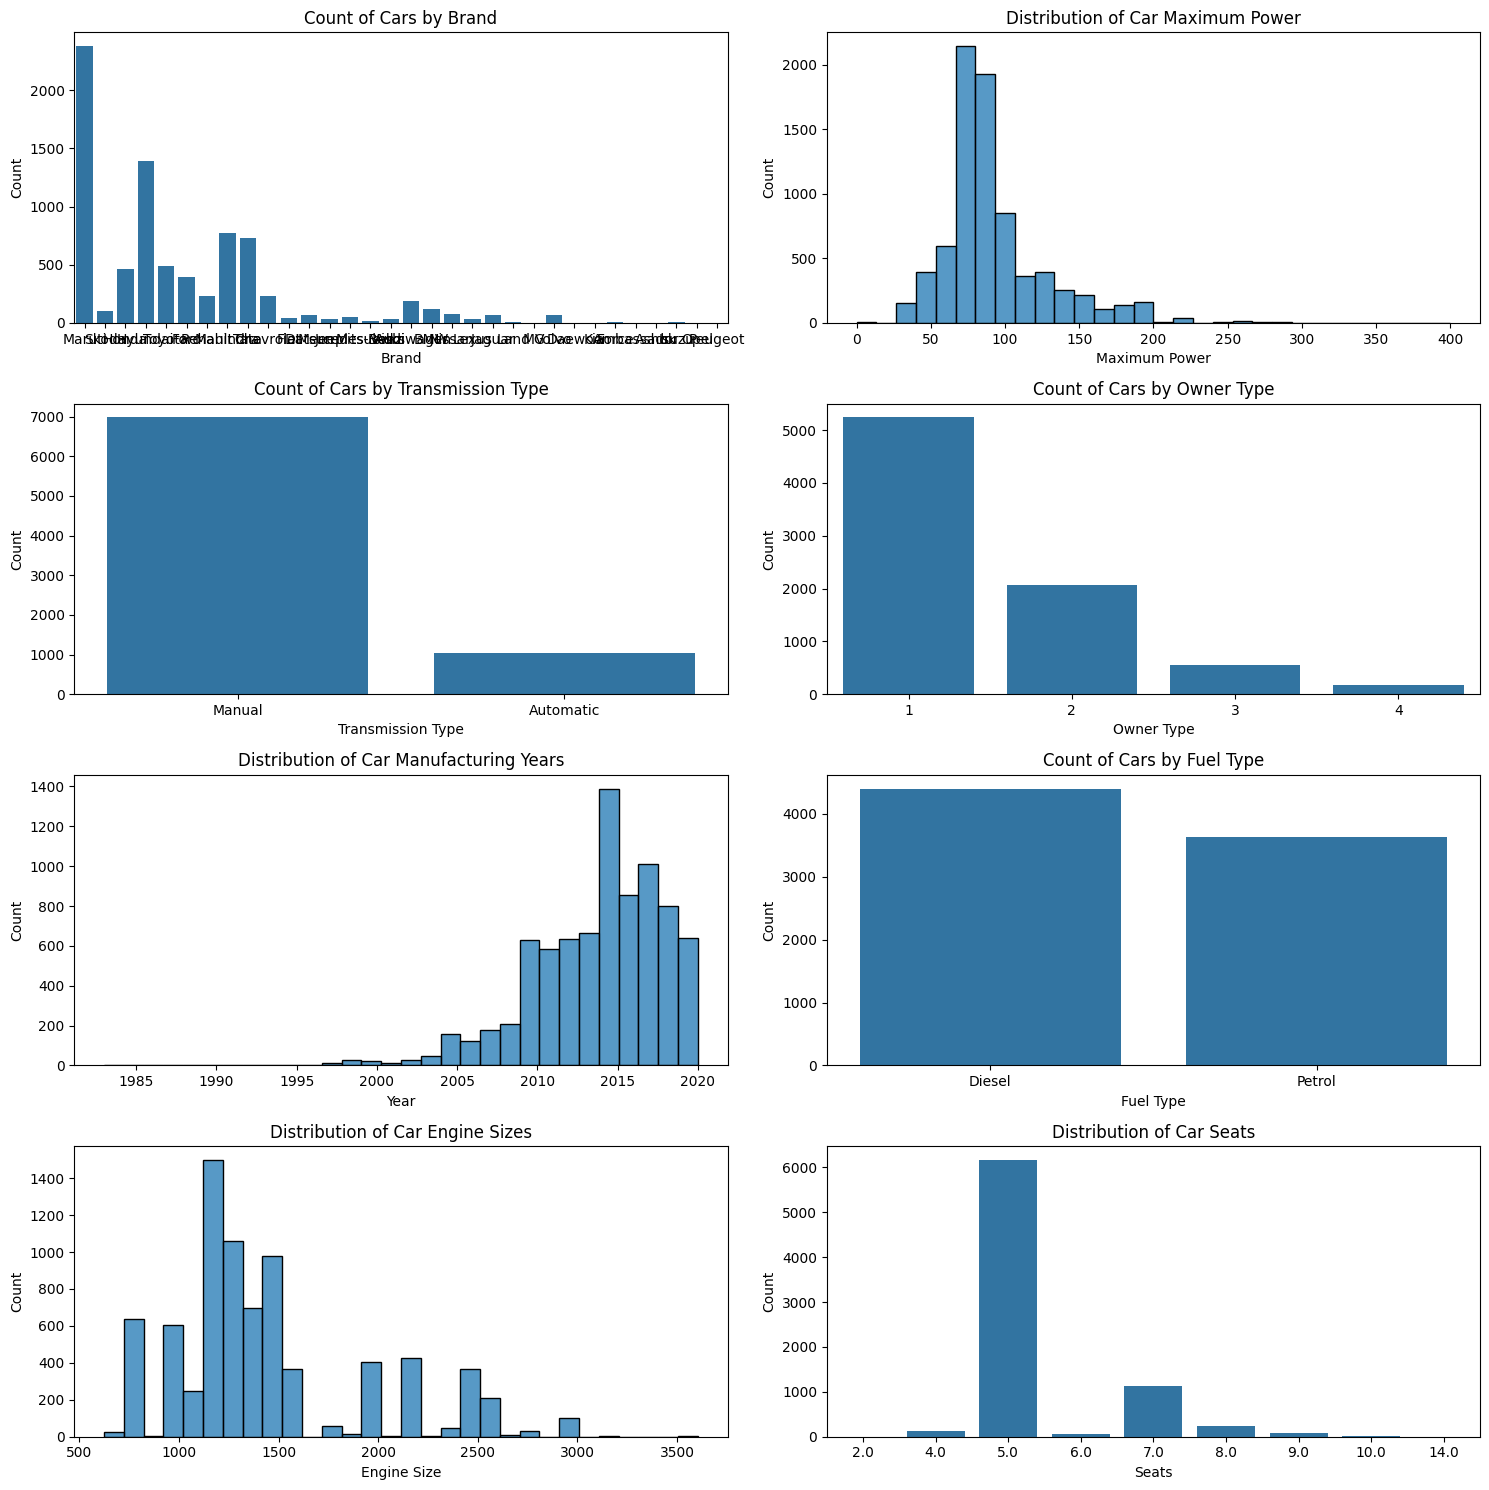

In [16]:
# Column list: 'brand', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type','transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats'
# y is selling_price
# Create a figure and a set of subplots for univariate analysis
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

# Count plot on brand to visualize the distribution of car brands
sns.countplot(data=df, x='brand', ax=axes[0, 0])
axes[0, 0].set_title('Count of Cars by Brand')
axes[0, 0].set_xlabel('Brand')
axes[0, 0].set_ylabel('Count')

# Histogram plot on max_power to visualize the distribution of car maximum power
sns.histplot(data=df, x='max_power', ax=axes[0, 1], bins=30)
axes[0, 1].set_title('Distribution of Car Maximum Power')
axes[0, 1].set_xlabel('Maximum Power')
axes[0, 1].set_ylabel('Count')

# Count plot on transmission to visualize the distribution of transmission types
sns.countplot(data=df, x='transmission', ax=axes[1, 0])
axes[1, 0].set_title('Count of Cars by Transmission Type')
axes[1, 0].set_xlabel('Transmission Type')
axes[1, 0].set_ylabel('Count')

# Count plot on owner to visualize the distribution of car owners
sns.countplot(data=df, x='owner', ax=axes[1, 1])
axes[1, 1].set_title('Count of Cars by Owner Type')
axes[1, 1].set_xlabel('Owner Type')
axes[1, 1].set_ylabel('Count')

# Histogram on year to visualize the distribution of car manufacturing years
sns.histplot(data=df, x='year', ax=axes[2, 0], bins=30)
axes[2, 0].set_title('Distribution of Car Manufacturing Years')
axes[2, 0].set_xlabel('Year')
axes[2, 0].set_ylabel('Count')

# Count plot on fuel to visualize the distribution of fuel types
sns.countplot(data=df, x='fuel', ax=axes[2, 1])
axes[2, 1].set_title('Count of Cars by Fuel Type')
axes[2, 1].set_xlabel('Fuel Type')
axes[2, 1].set_ylabel('Count')

# Histogram on engine to visualize the distribution of car engine sizes
sns.histplot(data=df, x='engine', ax=axes[3, 0], bins=30)
axes[3, 0].set_title('Distribution of Car Engine Sizes')
axes[3, 0].set_xlabel('Engine Size')
axes[3, 0].set_ylabel('Count')

# Distribution plot on seats to visualize the distribution of car maximum power
sns.countplot(data=df, x='seats', ax=axes[3, 1])
axes[3, 1].set_title('Distribution of Car Seats')
axes[3, 1].set_xlabel('Seats')
axes[3, 1].set_ylabel('Count')


plt.tight_layout()

Text(0, 0.5, 'Frequency')

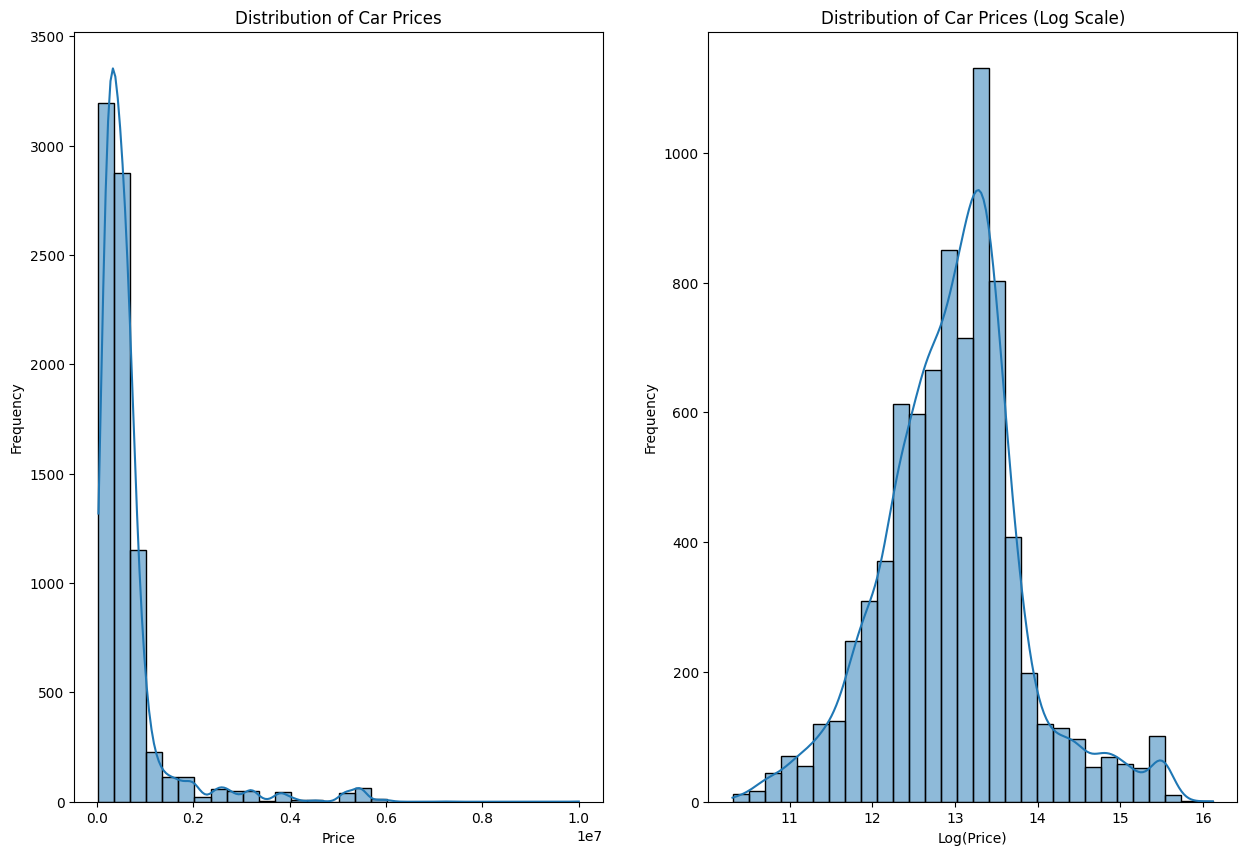

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Show the histogram of car prices between log and no log
sns.histplot(data=df, x='selling_price', bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Car Prices')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

sns.histplot(x=np.log1p(df['selling_price']), bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Car Prices (Log Scale)')
axes[1].set_xlabel('Log(Price)')
axes[1].set_ylabel('Frequency')


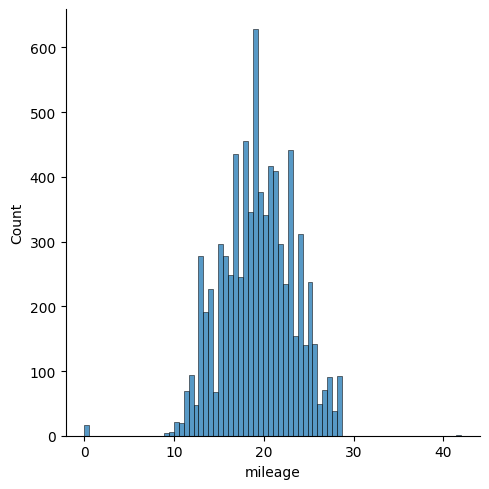

In [18]:
# Distribution plot on mileage to visualize the distribution of car mileage
sns.displot(data=df, x='mileage')


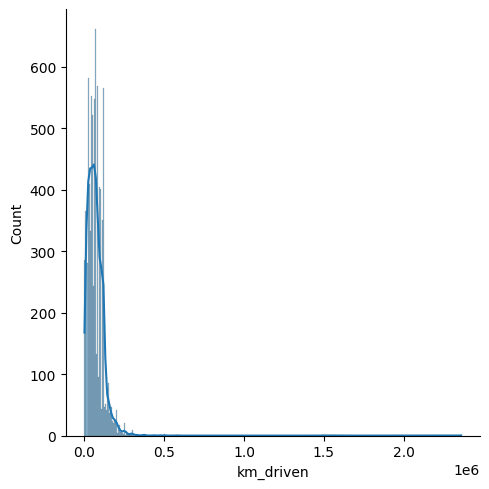

In [19]:
# Distribution plot of KM Driven
sns.displot(data=df, x='km_driven', kde=True)

From above univariate analysis, I found that:

- **Car Price** is right-skewed → log transform helps.  
- **Year** shows expected recency patterns.  
- **Km driven** is long-tailed (a few very high mileage cars).  
- **Engine / max_power / mileage** show realistic spread for typical segments.

#### Multivariate Analysis

<Axes: xlabel='transmission', ylabel='selling_price'>

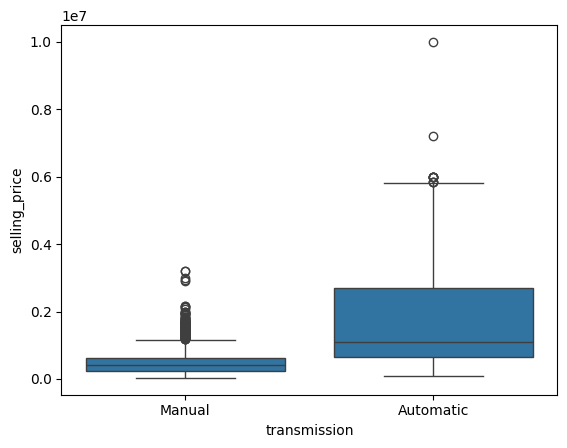

In [20]:
# Boxplot on transmission to visualize the distribution of car transmissions by selling price
sns.boxplot(data=df, x='transmission', y='selling_price')

Automatics priced higher, but mostly because they appear in premium cars.

<Axes: xlabel='brand', ylabel='selling_price'>

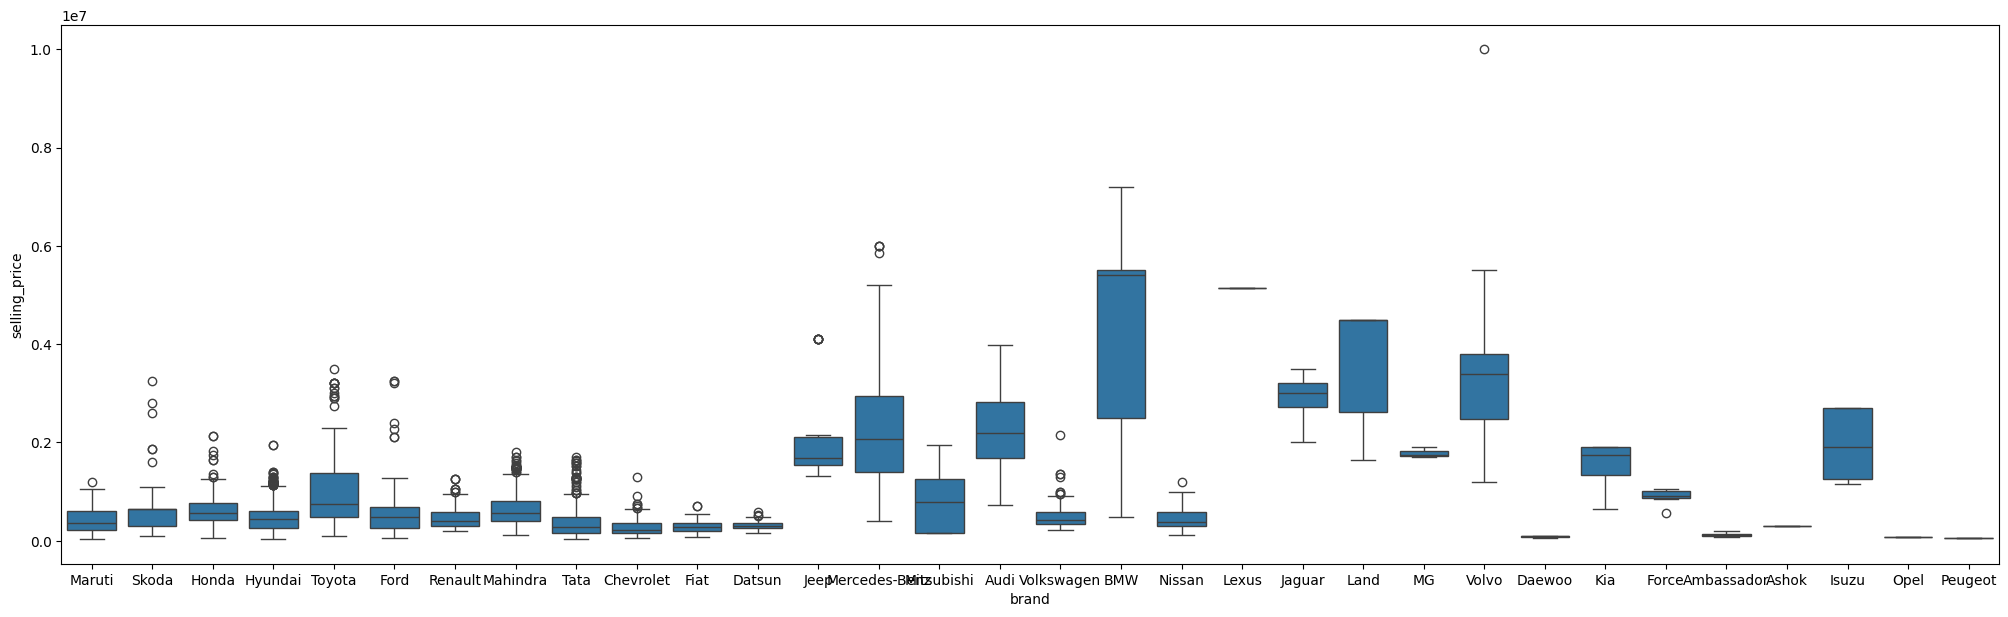

In [21]:
# Boxplot of Car Prices by Brand
plt.figure(figsize=(25, 7))
sns.boxplot(data=df, x='brand', y='selling_price')

Premium brands (BMW, Mercedes, Audi) consistently above mass-market.

<Axes: xlabel='owner', ylabel='selling_price'>

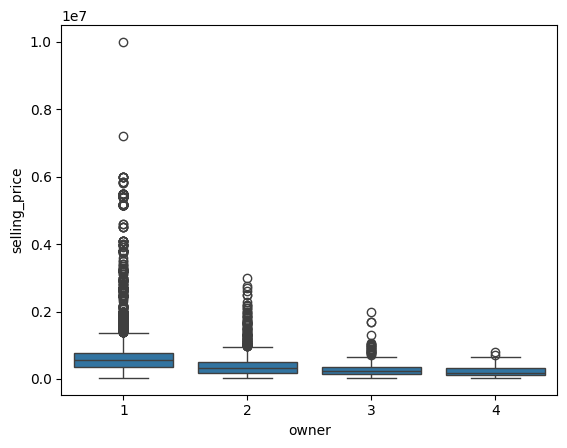

In [22]:
# Boxplot of Car Prices by Owner
sns.boxplot(data=df, x='owner', y='selling_price')

More owners = cheaper. Stepwise drop from 1 → 4.

<Axes: xlabel='max_power', ylabel='selling_price'>

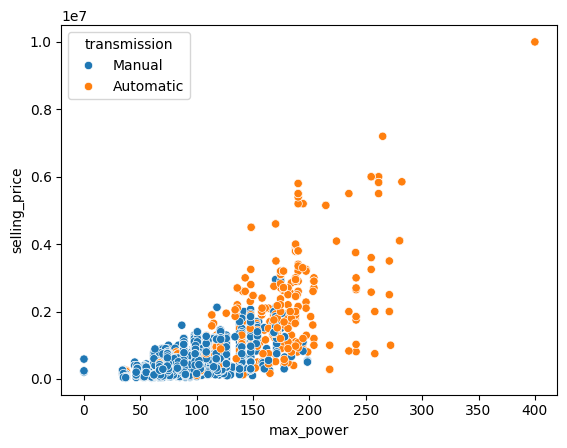

In [23]:
# Scatter plot on max_power vs selling price to visualize the relationship between car maximum power and selling price
sns.scatterplot(data=df, x='max_power', y='selling_price', hue='transmission')

Higher power → higher price, but slows after ~150 bhp. One extreme outlier.

<Axes: xlabel='year', ylabel='selling_price'>

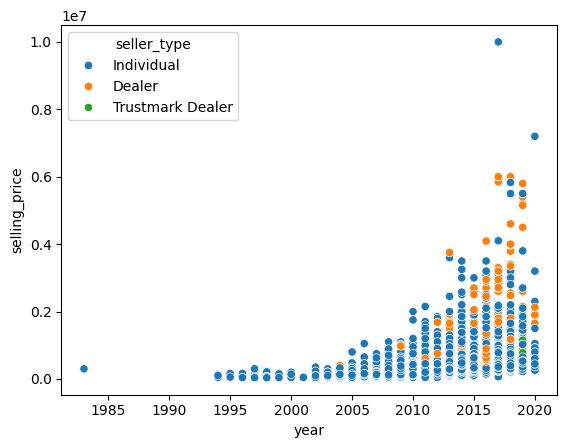

In [24]:
# Scatter plot on car manufacturing year vs selling price to visualize the relationship between car manufacturing year and selling price
sns.scatterplot(data=df, x='year', y='selling_price', hue='seller_type')


Newer cars cost more; steep rise after 2011.  

<Axes: xlabel='mileage', ylabel='selling_price'>

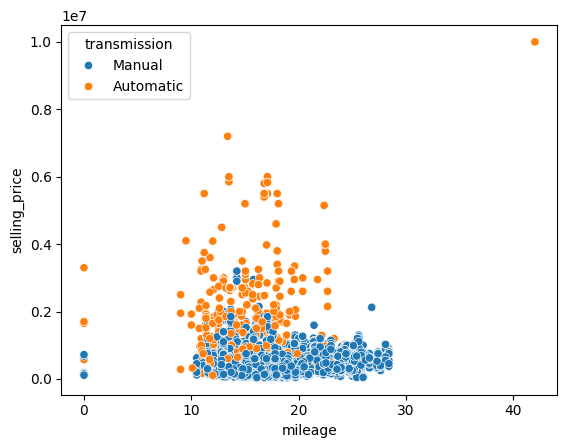

In [25]:
# Scatter plot on car mileage vs selling price to visualize the relationship between car mileage and selling price
sns.scatterplot(data=df, x='mileage', y='selling_price', hue='transmission')


Higher mileage (efficiency) cars tend to be mid-priced. Premium cars often low-efficiency.

<Axes: xlabel='engine', ylabel='selling_price'>

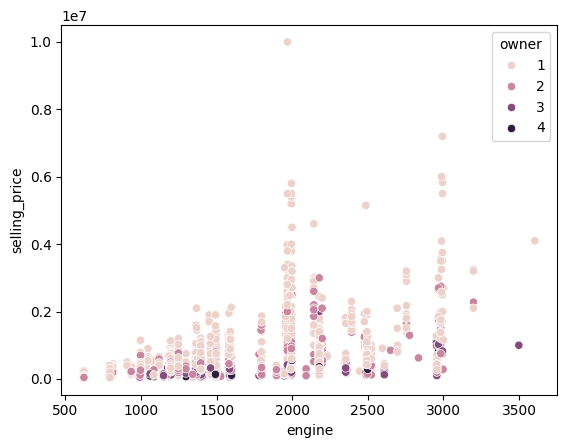

In [26]:
# Scatter plot of engine capacity vs selling price
sns.scatterplot(data=df, x='engine', y='selling_price', hue='owner')


Bigger engines cost more; overlaps with power. Popular bands (1200, 1500, 2000cc).

<Axes: xlabel='km_driven', ylabel='selling_price'>

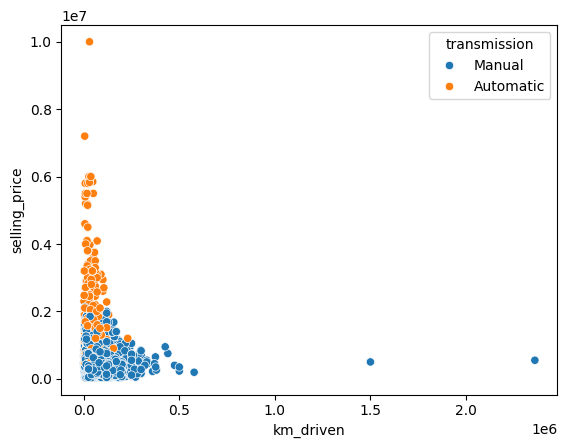

In [27]:
# Scatter plot km_driven vs selling price
sns.scatterplot(data=df, x='km_driven', y='selling_price', hue='transmission')

More km → lower price; steep drop early, then flattens. Outliers above 1M km.

### 1.3 Feature Engineering (Skip)

No synthetic features were added in this iteration to keep the pipeline transparent.

### 1.4 Feature Selection

In this part, I performs correlation matrix based on only train set to check which features should I select and make the selection.

In [28]:
from sklearn.model_selection import train_test_split

# Split training set and testing set
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

<Axes: >

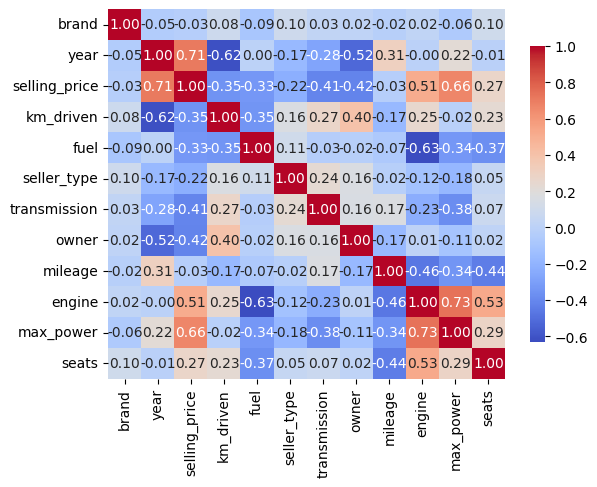

In [29]:
# Create a correlation matrix from training data to visualize relationships

from sklearn.preprocessing import LabelEncoder

# Create a copy for EDA
corr_train_set = train_set.copy(deep=True)

for col in corr_train_set.select_dtypes(include=[object]).columns:
    le = LabelEncoder()
    # Fit on only the training data (avoid data leakage)
    train_vals = corr_train_set[col].astype(str).fillna("MISSING")
    corr_train_set[col] = le.fit_transform(train_vals)
corr_matrix_train_enc = corr_train_set.select_dtypes(include=[np.number]).corr(method='spearman')
    
sns.heatmap(corr_matrix_train_enc, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})

In [30]:
# Display the correlation value related to selling_price
corr_matrix_train_enc['selling_price'].sort_values(ascending=False)

selling_price    1.000000
year             0.712011
max_power        0.664478
engine           0.510408
seats            0.268431
mileage         -0.027310
brand           -0.031312
seller_type     -0.223886
fuel            -0.334790
km_driven       -0.350329
transmission    -0.408235
owner           -0.415531
Name: selling_price, dtype: float64

In [31]:
# Select relevant features for the model
features = ['year', 'km_driven', 'fuel', 'transmission', 'owner',
            'engine', 'max_power', 'brand', 'mileage']
target = 'selling_price'
print(features)

['year', 'km_driven', 'fuel', 'transmission', 'owner', 'engine', 'max_power', 'brand', 'mileage']


Reasons for selecting these features for predicting `selling_price`
- **year, km_driven** → capture age and usage (depreciation/wear).  
- **fuel, transmission, owner** → reflect demand and perceived risk.  
- **engine, max_power** → represent vehicle segment and performance.  
- **mileage** → indicates operating cost.  
- **brand** → conveys reputation and reliability premium.  

### 1.5 Preprocessing

In this part, I do the preprocessing process to the data by create the pipeline that includes:

- **Imputation**: median for robust numerics (mean for `mileage` if desired).  
- **Scaling**: `StandardScaler` for numeric features.  
- **One-hot**: `handle_unknown='ignore'`, `drop='first'` to avoid dummy traps.  
- **Train/Test split**: 80/20 with fixed seed.  
- **Target**: model on **log(selling_price)**.

In [32]:
# Create feature sets for numerical and categorical features
features_num = [ft for ft in features if train_set[ft].dtype in [np.float64, np.int64]]
features_cat = [ft for ft in features if train_set[ft].dtype == 'object']

print("Numerical features:", features_num)
print("Categorical features:", features_cat)

Numerical features: ['year', 'km_driven', 'owner', 'engine', 'max_power', 'mileage']
Categorical features: ['fuel', 'transmission', 'brand']


In [33]:
# Split the data into features and target label
X_train = train_set[features].copy()
X_test = test_set[features].copy()
y_train = np.log(train_set[target]).copy() # Use log transformation for skewed target
y_test = np.log(test_set[target]).copy()



In [34]:
# Create a pipeline for preprocessing and modeling
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Define the preprocessing steps for numerical and categorical features

# Numerical features pipeline that use median to fill missing values
numeric_transformer_med = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Numerical features pipeline that use mean to fill missing values
numeric_transformer_mean = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
   ('scaler', StandardScaler())
])

# Categorical features pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine all transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num_med', numeric_transformer_med, [col for col in features_num if col != 'mileage']),
        ('num_mean', numeric_transformer_mean, ['mileage']),
        ('cat', categorical_transformer, features_cat)
    ]
)

print("The shape of training data is:", X_train.shape)
print("The shape of test data is:", X_test.shape)
print("The shape of training label is:", y_train.shape)
print("The shape of test label is:", y_test.shape)

The shape of training data is: (6422, 9)
The shape of test data is: (1606, 9)
The shape of training label is: (6422,)
The shape of test label is: (1606,)


### 1.6 Modeling

In this part, I select models for modeling include:

- Linear Regression: fast, interpretable baseline.
- Decision Tree: learns splits/thresholds; can overfit.
- Random Forest: robust bagging; strong tabular baseline.
- Gradient Boosting: additive learners; great bias–variance tradeoff.
- Support Vector Machine: flexible kernels; benefits from scaling.
- XGBoost: industrial-strength boosting with regularization.

In [35]:
# Import models which are going to use
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

In [36]:
# Create a list of algorithms wrapped in a pipeline with preprocessing
algorithms = [
    ('Linear Regression', Pipeline([('preprocessor', preprocessor), ('model', LinearRegression())])),
    ('Decision Tree', Pipeline([('preprocessor', preprocessor), ('model', DecisionTreeRegressor(random_state=321))])),
    ('Random Forest', Pipeline([('preprocessor', preprocessor), ('model', RandomForestRegressor(random_state=321))])),
    ('Gradient Boosting', Pipeline([('preprocessor', preprocessor), ('model', GradientBoostingRegressor(random_state=321))])),
    ('Support Vector Machine', Pipeline([('preprocessor', preprocessor), ('model', SVR())])),
    ('XGBoost', Pipeline([('preprocessor', preprocessor), ('model', XGBRegressor(random_state=321))]))
]

# Do the cross validation
# Define splitter
kf = KFold(n_splits=5, shuffle=True, random_state=321)

# Evaluate each model
for name, model in algorithms:
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    print(f"{name} - Score: {scores}; Mean: {np.mean(scores)}")

Linear Regression - Score: [-0.06398447 -0.05777076 -0.06680223 -0.07806821 -0.07342214]; Mean: -0.06800956314506681


/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Decision Tree - Score: [-0.07237361 -0.07097165 -0.08673554 -0.08903802 -0.07659315]; Mean: -0.07914239375776345


/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Random Forest - Score: [-0.04297491 -0.0382171  -0.04942952 -0.05076761 -0.04786001]; Mean: -0.04584982887417668


/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Gradient Boosting - Score: [-0.04792226 -0.04229755 -0.05376902 -0.05527359 -0.05369693]; Mean: -0.050591869985153436


/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Support Vector Machine - Score: [-0.04655032 -0.03989142 -0.05106174 -0.05036213 -0.05051655]; Mean: -0.04767643365750607


/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


XGBoost - Score: [-0.04406553 -0.03862856 -0.04741739 -0.04997252 -0.04765917]; Mean: -0.045548635875937084


#### Performing Grid Search on Random Forest Regression and XGBoost

I tune the two strongest model from cross-validation:

1. Random Forest with parameters 
   - Trees: 5–15; 
   - Depth: 5, 10, None; 
   - Bootstrap: True.
2. XGBoost with parameters
   - n_estimators: 300–800; 
   - max_depth: 4–8; 
   - learning_rate: 0.03–0.1.

In [37]:
# Perform Grid Search for XGBoost

param_xgb = {
    'model__n_estimators':      [300, 500, 800],
    'model__max_depth':         [4, 6, 8],
    'model__learning_rate':     [0.03, 0.05, 0.1]
}

# Perform grid search
grid_search_xgb = GridSearchCV(estimator=algorithms[-1][1], param_grid=param_xgb, cv=kf, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)


/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warning

,estimator,"Pipeline(step...e=321, ...))])"
,param_grid,"{'model__learning_rate': [0.03, 0.05, ...], 'model__max_depth': [4, 6, ...], 'model__n_estimators': [300, 500, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num_med', ...), ('num_mean', ...), ...]"


In [38]:
print("Best parameters for XGBoost:")
print(grid_search_xgb.best_params_)
print("Best score for XGBoost:")
print(grid_search_xgb.best_score_)

Best parameters for XGBoost:
{'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 500}
Best score for XGBoost:
-0.04220791279083505


In [39]:
# Perform grid search on Random Forest Regression
param_rf = {
    'model__bootstrap': [True],
    'model__max_depth': [5, 10, None],
    'model__n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
}

# Perform grid search
grid_search_rf = GridSearchCV(estimator=algorithms[2][1], param_grid=param_rf, cv=kf, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warning

,estimator,Pipeline(step..._state=321))])
,param_grid,"{'model__bootstrap': [True], 'model__max_depth': [5, 10, ...], 'model__n_estimators': [5, 6, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num_med', ...), ('num_mean', ...), ...]"


In [40]:
# Print best parameters and score for Random Forest
print("Best parameters for Random Forest:")
print(grid_search_rf.best_params_)
print("Best score for Random Forest:")
print(grid_search_rf.best_score_)

Best parameters for Random Forest:
{'model__bootstrap': True, 'model__max_depth': None, 'model__n_estimators': 15}
Best score for Random Forest:
-0.04831892534845171


### 1.7 Testing

In this part, I report:
- **MSE (log scale)** — aligned with training objective.  
- **RMSE (original currency)** — intuitive error in monetary terms.  
- **R² (log scale)** — explained variance.

In [41]:
# Make a prediction using the best model
best_model = grid_search_xgb.best_estimator_ if grid_search_xgb.best_score_ > grid_search_rf.best_score_ else grid_search_rf.best_estimator_

# Find the name of the best model from the algorithms list
for name, model in algorithms:
	# Compare the model steps (ignoring fitted parameters)
	if type(model.named_steps['model']) == type(best_model.named_steps['model']):
		best_model_name = name
		break

print("Best model:", best_model_name)

# Make predictions
y_pred = best_model.predict(X_test)


Best model: XGBoost


/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### **Evaluation Metrics**

- **Mean Squared Error (MSE)**  
  The average squared difference between the true and predicted values.  
  ```math
  MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2

- **Root Mean Squared Error (RMSE)**  
  The square root of the MSE, putting the error back into the same units as the target variable.  
  ```math
  RMSE = \sqrt{MSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}

- **Mean Absolute Error (MAE)**  
  The average absolute difference between the true and predicted values. It is less sensitive to outliers than MSE.  
  ```math
  MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|

- **Mean Absolute Percentage Error (MAPE)**  
  The average percentage error between the true and predicted values.  
  ```math
  MAPE = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|

- **Coefficient of Determination (R² Score)**  
  The proportion of the variance in the dependent variable that is predictable from the independent variable(s).  

```math
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}

In [42]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Evaluate model performance
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
print("Mean Squared Error (Base on real price) for model:")
print(mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (Base on real price) for model:")
print(rmse)
mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred))
print("Mean Absolute Error (Base on real price) for model:")
print(mae)
mape = np.mean(np.abs((np.exp(y_test) - np.exp(y_pred)) / np.exp(y_test))) * 100
print("Mean Absolute Percentage Error (Base on real price) for model:")
print(mape)
r2 = r2_score(np.exp(y_test), np.exp(y_pred))
print("R^2 Score for model:")
print(r2)

Mean Squared Error (Base on real price) for model:
42385634536.84427
Root Mean Squared Error (Base on real price) for model:
205877.7174364537
Mean Absolute Error (Base on real price) for model:
70849.72544121653
Mean Absolute Percentage Error (Base on real price) for model:
14.306886860520187
R^2 Score for model:
0.9452529858902042


The model explains about 94.5% of price variation. On average, it misses by ~71K or ~14%. A few luxury cars create bigger errors (raising RMSE to ~205K), but for most cars the predictions are very close to reality.

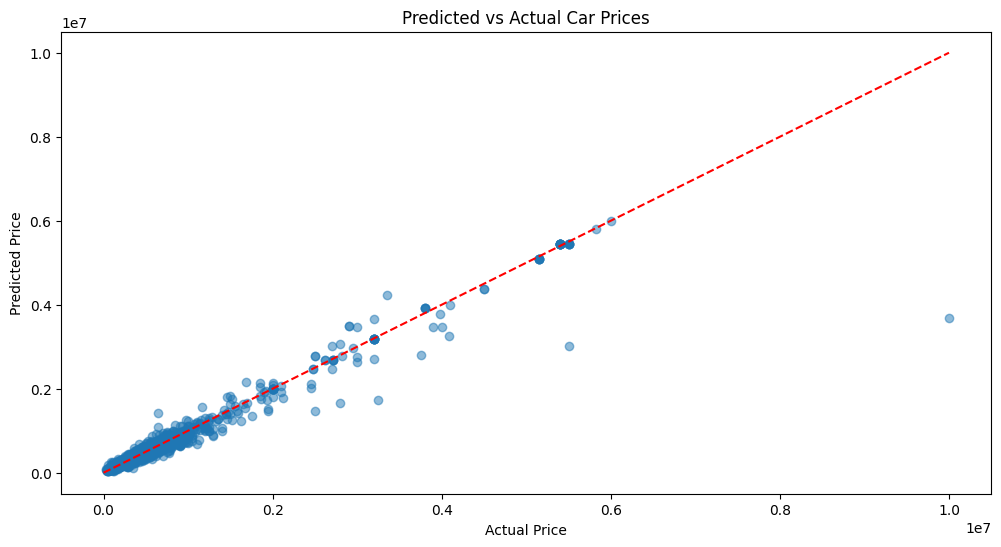

In [43]:
# Show the graph comparing between train set selling price and predicted price
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(np.exp(y_test), np.exp(y_pred), alpha=0.5)
plt.plot([0, max(np.exp(y_test))], [0, max(np.exp(y_test))], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Car Prices")
plt.show()

This plot shows the model predicts most car prices well, with points close to the ideal line. Errors get larger for very expensive cars, and a few outliers pull the line, but overall the model does a good job.

### 1.8 Analysis: Feature Importance

/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A1 - Predicting Car Prices/Predicting-Car-Prices/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warning

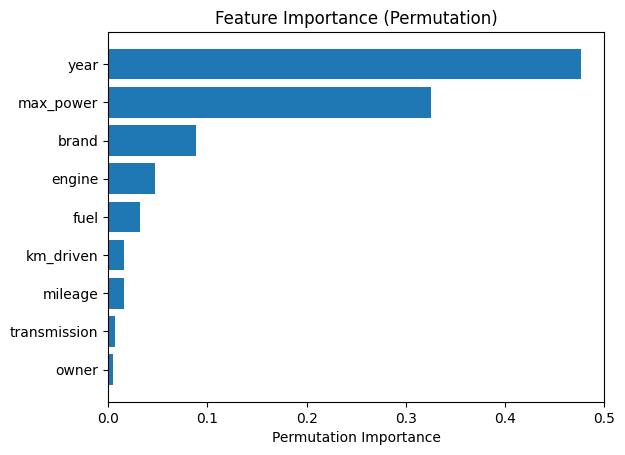

In [44]:
# Use permutation way to visualize the feature importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(best_model, X_test, y_test, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Permutation)")
plt.show()

The graph illustrates that **year, max_power, and brand** are the top three important features of car prices.  
- **Year** → Newer cars are worth more, making age the strongest predictor.  
- **Max Power** → Cars with more powerful engines tend to sell at higher prices.  
- **Brand** → Premium brands (e.g., BMW, Mercedes) carry a strong price premium, even after accounting for specs.  

Other features like **engine size, fuel type, transmission, mileage, and ownership** still matter, but their impact is smaller once the main factors are considered.

### 1.9 Inference

For inference, I saved the trained pipeline and used it to predict on unseen data, simulating real-world usage. This ensures that all preprocessing steps (cleaning, encoding, scaling) are applied consistently before generating the predicted selling price.

In [45]:
# Import joblib for model
import pickle

# Save the model
filename = "../model/car_price.model"
with open(filename, 'wb') as f:
    pickle.dump(best_model, f)

In [46]:
# Load the model
with open(filename, 'rb') as f:
    loaded_model = pickle.load(f)

In [47]:
# Create an example input
example_input = {
    'year': 2020,
    'km_driven': 15000,
    'fuel': 'Petrol',
    'transmission': 'Manual',
    'owner': 1,
    'engine': 1500,
    'max_power': 100,
    'brand': 'Toyota',
    'mileage': 15
}

# Predict the price for the example input
example_df = pd.DataFrame([example_input])
price_hat_log = loaded_model.predict(example_df[features])
price_hat = np.exp(price_hat_log)
print("Example input:")
print(example_input)
print(f"Predicted price: {price_hat[0]:.2f}")

Example input:
{'year': 2020, 'km_driven': 15000, 'fuel': 'Petrol', 'transmission': 'Manual', 'owner': 1, 'engine': 1500, 'max_power': 100, 'brand': 'Toyota', 'mileage': 15}
Predicted price: 780965.25


## Task 2. Report

After cleaning the data (e.g., fixing units, removing outliers like test-drive cars, and log-transforming the target), I looked at which inputs actually move the price needle. The permutation importance plot makes the story plain: year is the biggest lever, with max_power close behind. That lines up with common sense—newer cars and stronger engines tend to command higher prices. Brand still matters even after accounting for specs, which suggests reputation and perceived reliability carry real weight. By comparison, engine (displacement), mileage, km_driven, and fuel type add smaller, secondary signals once year and power are known. Ownership count and transmission barely register in this dataset, implying buyers anchor more on age, performance, and badge than on manual vs. automatic or how many people owned the car before.

On modeling, I started with Linear Regression as a sanity check and quickly ran into its limits: price doesn’t change in a straight line with any single feature, and interactions (e.g., how brand moderates the effect of year) matter. Tree-based ensembles handled that structure better. Random Forest improved accuracy by averaging many diverse trees, but XGBoost was the most reliable overall: its boosting process chips away at residual errors round by round, which helped it capture non-linear effects without blowing up variance. In short, linear models were a decent baseline for interpretability, but they underfit; boosted trees struck the best balance of bias and variance on this tabular problem.

In practice, that leaves a simple takeaway: focus on getting year, power, and brand represented cleanly (and consistently encoded), keep the label in log space for stability, and prefer ensemble methods that can learn interactions. The remaining features still help at the margins, but most of the predictive lift comes from those first three. If I had more time, I’d probe feature interactions explicitly (partial dependence/SHAP) and test a few regularization settings and learning-rate schedules in XGBoost to see if I can shave a bit more error without sacrificing generalization.

## Task 3. Deploy
Github Link: https://github.com/dniamsaard4codework/Predicting-Car-Prices.git